In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA


In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows to confirm successful loading
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [5]:
print(transactions.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')


In [9]:
# Now, use Price_y (from products dataset) for the aggregation
customer_features = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total spending of the customer
    'Quantity': 'sum',           # Total quantity of items bought by the customer
    'Price_y': 'mean',           # Average price of items bought by the customer
    'TransactionID': 'count'     # Number of transactions made by the customer
}).rename(columns={
    'TotalValue': 'Total_Spent',
    'Quantity': 'Total_Quantity',
    'Price_y': 'Average_Price',
    'TransactionID': 'Transaction_Count'
})

# Normalize the aggregated data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Convert back to DataFrame
scaled_features = pd.DataFrame(scaled_features, columns=customer_features.columns, index=customer_features.index)

# Proceed with clustering...


In [10]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can experiment with 2-10 clusters
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
customer_features['Cluster'] = clusters

# Evaluate with Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.966505237178532


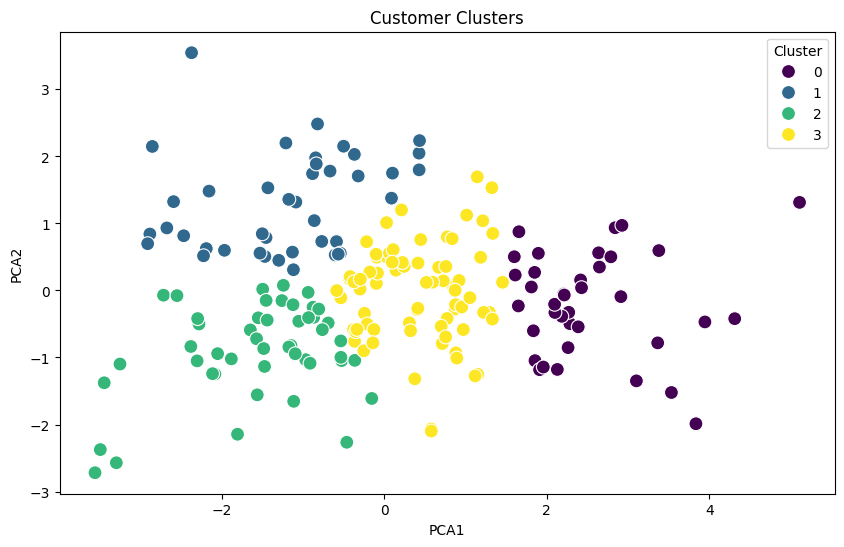

In [11]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add reduced dimensions to DataFrame
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis', s=100
)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [12]:
# Analyze clusters
cluster_summary = customer_features.groupby('Cluster').mean()
print(cluster_summary)


         Total_Spent  Total_Quantity  Average_Price  Transaction_Count  \
Cluster                                                                  
0        6136.099189       22.027027     282.056979           8.162162   
1        2504.780488        7.146341     346.552789           2.975610   
2        1670.598333        8.312500     196.470160           3.354167   
3        3836.646164       14.109589     274.023137           5.684932   

             PCA1      PCA2  
Cluster                      
0        2.538655 -0.198718  
1       -1.208137  1.294575  
2       -1.560492 -0.891850  
3        0.417904 -0.039948  


In [13]:
# Save the notebook (manually from Jupyter)
# Export the cluster summary as CSV
cluster_summary.to_csv('Cluster_Summary.csv')
